In [3]:
%matplotlib inline
import pickle
from igraph import *
import pylab as plt
import numpy as np
import random
import sys
import time
import math
from scipy.stats import multivariate_normal,gamma
from collections import Counter
from scipy.linalg import solve, sqrtm, norm

In [4]:
class Stopwatch:
    start_time=None
    def go(self,msg=''):
        if msg:
            print msg,
        self.start_time=time.time()
        sys.stdout.flush()
    def stop(self,msg=''):
        if msg:
            print "{}: {} seconds".format(msg,time.time()-self.start_time)
        else:
            print "Elapsed time: {} seconds".format(time.time()-self.start_time)
        sys.stdout.flush()
    def check(self):
        return time.time()-self.start_time

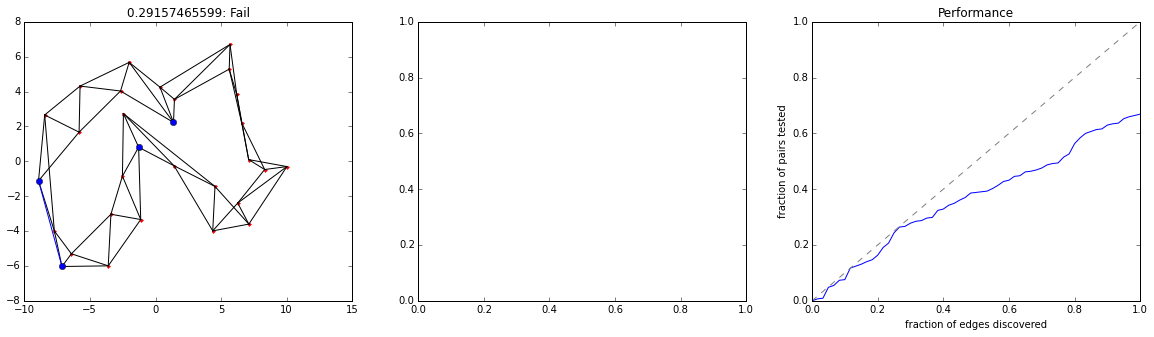

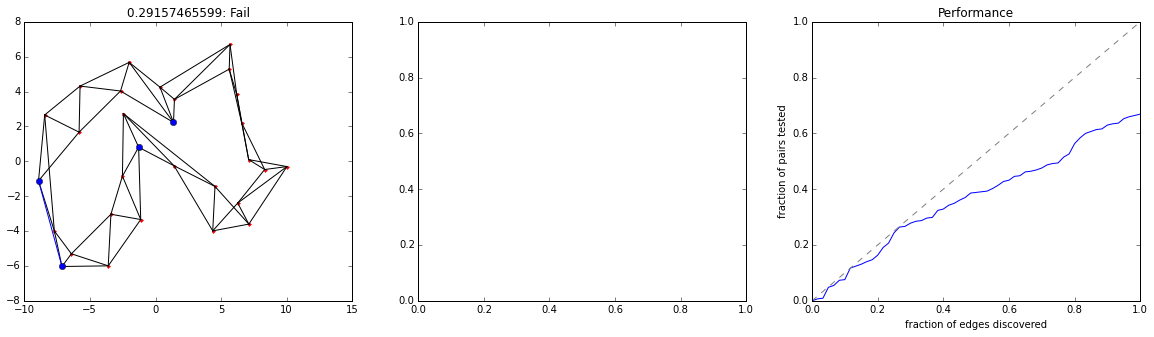

In [23]:
from IPython import display
fig=plt.figure(figsize=(20,5))
ax1=fig.add_subplot(1,3,1)
ax2=fig.add_subplot(1,3,2)
ax3=fig.add_subplot(1,3,3)

tic=Stopwatch()
tic.go()
N=30 # no. of nodes
M=200 # no. of edges
#G=Graph.Erdos_Renyi(n=N,m=M)
#G=Graph.Barabasi(n=N,m=4)
G=Graph.Watts_Strogatz(1, N, 2, 0, loops=False, multiple=False)
#G=pickle.load(open('gene_network_0.08.pkl'))
#G=G.subgraph(random.sample(xrange(G.vcount()),N))
#G.simplify()
V=range(G.vcount()) # set of nodes
M=G.ecount()
N=G.vcount()
tic.stop('Load network')

tic.go()
tests=0
Gh=Graph(N,directed=False) # start from an empty graph
tested=dict()
found=0
cost_ls=[0]
testu=Counter()
u=random.choice(V)
v=random.choice(V)
testu.update([u,v])
Z=[u,v]
eid=G.get_eid(u,v,False,False)
tests+=1
if eid==-1:
    tested[tuple(sorted((u,v)))]=0
else:
    tested[tuple(sorted((u,v)))]=1
    found+=1
    cost_ls.append(tests)
    Gh.add_edge(u,v)
    
X0=np.random.randn(2,N)
X=X0.copy()
X2=np.zeros_like(X)
a=2
D=dict()
D[tuple(sorted((u,v)))]=norm(X[:,u]-X[:,v])
if tested[tuple(sorted((u,v)))]==1:
    f=1/(1+np.exp(D[tuple(sorted((u,v)))]-a))
else:
    f=1/(1+np.exp(a-D[tuple(sorted((u,v)))]))
iters=1000
varD0=dict()
varD1=dict()
noiselink=np.argmax(G.edge_betweenness())
noiselink=tuple(sorted((G.es[noiselink].source,G.es[noiselink].target)))

ax1.clear()
ax1.plot(X[0,Z],X[1,Z],'r.')
display.clear_output(wait=True)
display.display(plt.gcf())
plt.pause(1)
while found<G.ecount():
    Dh=dict()
    for i in Z:
        for j in Z:
            if (j>i) and ((i,j) not in tested):
                Dh[(i,j)]=0
    for t in xrange(iters):
        # update position Z first
        X2[:,Z]=X[:,Z]+np.random.randn(2,len(Z))*0.2 # propose new positions of nodes
        D2=dict() # calculate distance between new positions
        f2=1 # likelihood of the new model
        for e in tested:
            D2[e]=norm(X2[:,e[0]]-X2[:,e[1]])
            if tested[e]==1:
                f2*=1/(1+np.exp(D2[e]-a))
            else:
                f2*=1/(1+np.exp(a-D2[e]))
        prior=1
        prior2=1
        for i in Z:
            prior*=multivariate_normal.pdf(X[:,i], mean=np.zeros(2), cov=100)
            prior2*=multivariate_normal.pdf(X2[:,i], mean=np.zeros(2), cov=100)
        if random.random()<f2/f*prior2/prior:
            D=D2
            f=f2
            A=X2[:,Z]-X2[:,Z].mean(axis=1).reshape(2,1)+X0[:,Z].mean(axis=1).reshape(2,1)
            A0=X0[:,Z]
            X[:,Z]=A0.dot(A.T).dot(solve(sqrtm(A.dot(A0.T).dot(A0).dot(A.T)),A))
        # update a
        a2=abs(a+random.uniform(-0.5,0.5))
        f2=1 # likelihood of the new model
        for e in tested:
            if tested[e]==1:
                f2*=1/(1+np.exp(D[e]-a2))
            else:
                f2*=1/(1+np.exp(a2-D[e]))
        if random.random()<f2/f*gamma.pdf(a2, 1,scale=1)/gamma.pdf(a, 1,scale=1):
            a=a2
            f=f2
        # update distance for untested pairs
        if t>=iters*0.5:
            for i in Z:
                for j in Z:
                    if (j>i) and ((i,j) not in tested):
                        Dh[(i,j)]+=norm(X[:,i]-X[:,j])
    ### Drawing
    ax1.clear()
    ax1.plot(X[0,Z],X[1,Z],'r.')
    _=[ax1.plot(X[0,e],X[1,e],'k') for e in tested if tested[e]==1]
    ### Drawing
    for e in Dh:
        Dh[e]=1/(1+np.exp(Dh[e]/iters/0.5-a))
    while Dh and found<G.ecount():
        u,v=max(Dh, key=Dh.get)  # propose a pair to test
        eid=G.get_eid(u,v,False,False)
        testu.update([u,v])
        tests+=1
        ### Drawing
        ax2.clear()
        ax2.plot(np.arange(0.,len(cost_ls))/M, np.array(cost_ls)/(0.5*N*(N-1)))
        ax2.plot([0,1],[0,1],'--',color='grey')
        ax2.set_title("Performance")
        ax2.set_xlabel("fraction of edges discovered")
        ax2.set_ylabel("fraction of pairs tested")
        ### Drawing
        if eid!=-1:
            ### Drawing
            ax1.plot(X[0,[u,v]],X[1,[u,v]],'bo-')
            ax1.set_title(str(Dh[u,v])+": Succeed")
            display.clear_output(wait=True)
            display.display(plt.gcf())
            plt.pause(0.01)
            ### Drawing
            tested[(u,v)]=1
            found+=1
            cost_ls.append(tests)
            Gh.add_edge(u,v)
            D[(u,v)]=norm(X[:,u]-X[:,v])
            f*=1/(1+np.exp(D[(u,v)]-a))
            Dh.pop((u,v),None)
        else:
            ### Drawing
            ax1.plot(X[0,[u,v]],X[1,[u,v]],'bo')
            ax1.set_title(str(Dh[u,v])+": Fail")
            display.clear_output(wait=True)
            display.display(plt.gcf())
            plt.pause(0.01)
            ### Drawing
            tested[(u,v)]=0
            D[(u,v)]=norm(X[:,u]-X[:,v])
            f*=1/(1+np.exp(a-D[(u,v)]))
            break
    if Dh and (found/8.0>tests/N or len(Z)>=N):
        continue
    u=Z[np.argmax(Gh.degree(Z))]
    v=random.choice(np.setdiff1d(V,Z))
    eid=G.get_eid(u,v,False,False)
    testu.update([u,v])
    tests+=1
    if eid==-1:
        X[:,v]=np.random.randn(2)*20
        for i in Z:
            D[tuple(sorted([i,v]))]=norm(X[:,i]-X[:,v])
        tested[tuple(sorted((u,v)))]=0
        f*=1/(1+np.exp(a-D[tuple(sorted([u,v]))]))
        ### Drawing
        ax1.set_title(str(len(Z))+": Exploration Fail")
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.pause(0.01)
        ### Drawing
    else:
        X[:,v]=X[:,u]+np.random.randn(2)*0.2
        for i in Z:
            D[tuple(sorted([i,v]))]=norm(X[:,i]-X[:,v])
        tested[tuple(sorted((u,v)))]=1
        found+=1
        cost_ls.append(tests)
        Gh.add_edge(u,v)
        f*=1/(1+np.exp(D[tuple(sorted((u,v)))]-a))
        ### Drawing
        ax1.set_title(str(len(Z))+": Exploration Succeed")
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.pause(0.01)
        ### Drawing
    Z.append(v)